In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd, YearEnd
import datetime as dt
import matplotlib.pyplot as plt
import os
os.chdir("/Users/charlesrambo/Desktop/QIII/Quantitative Asset Management")

In [2]:
# Load stock information
stocks = pd.read_csv("stocks.csv")

In [3]:
# Record CRSP unkowns
unknowns = ["-66.0", "-77.0", "-88.0", "-99.0", "-99.99", "-999", "A", "B", "C", "D", "E", "S", "T", "P"]

# Create function to convert CRISP unkowns to np.nan
convert_unknows = lambda x: np.nan if x in unknowns else x

In [4]:
# Convert date column to date-time object
stocks['date'] = pd.to_datetime(stocks['date'], format = '%Y%m%d')

# Record observations where both returns and delisting returns are missing
stocks['flag'] = stocks['RET'].isna() & stocks['DLRET'].isna()

# Fill missing returns with 0
stocks['RET'] = stocks['RET'].apply(convert_unknows).astype(float).fillna(0)

# Fill missing delisting returns with 0
stocks['DLRET'] = stocks['DLRET'].apply(convert_unknows).astype(float).fillna(0)

# Compute log returns of the product
stocks['RET'] = np.log((1 + stocks['RET']) * (1 + stocks['DLRET']))

#Make stale prices positive
stocks['PRC'] = stocks['PRC'].abs()

# Remove 0 priced observations
stocks = stocks.loc[stocks['PRC'] > 0]

# Remove non-psitive shares outstanding
stocks = stocks.loc[stocks['SHROUT'] > 0]

# Only consider stocks listed on the big exchanges
stocks = stocks.loc[stocks['SHRCD'].isin([10, 11]) & stocks['EXCHCD'].isin([1, 2, 3])]

# Drop unneeded columns
stocks.drop(['DLRET', 'SHRCD', 'EXCHCD', 'PERMCO'], axis = 1, inplace = True)

/Users/charlesrambo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# Calculate market equity
stocks['ME'] = stocks['PRC'] * stocks['SHROUT']

# Short values for shift
stocks.sort_values(by = ['PERMNO', 'date'], inplace = True)

# Record the shifts which are valid
stocks['Isvalid'] = stocks['date'] + MonthEnd(0) == stocks['date'].shift(1) + dt.timedelta(days = 7) + MonthEnd(0)
stocks.loc[stocks['Isvalid'] == True, 'Isvalid'] = stocks.loc[stocks['Isvalid'] == True, 'PERMNO'] == stocks.loc[stocks['Isvalid'] == True, 'PERMNO'].shift(1)

# Shift market equity
stocks['ME_lag'] = stocks[['PERMNO', 'ME']].groupby('PERMNO')['ME'].shift(1)

# Replace the invalids with nan
stocks.loc[stocks['Isvalid'] == False, 'ME_lag'] = np.nan

# Drop unneeded columns
stocks.drop(['ME', 'Isvalid'], axis = 1, inplace = True)

In [6]:
# Sort values again for another shift
stocks.sort_values(by = ['PERMNO', 'date'], inplace = True)

# Check to see if valid
stocks['Isvalid'] = stocks['date'] + MonthEnd(0) == stocks['date'].shift(12) + dt.timedelta(days = 7) + MonthEnd(12)
stocks.loc[stocks['Isvalid'] == True, 'Isvalid'] = stocks.loc[stocks['Isvalid'] == True, 'PERMNO'] == stocks.loc[stocks['Isvalid'] == True, 'PERMNO'].shift(12)

# Calculate momentum signal
stocks['MOM'] = stocks['RET'].shift(2).rolling(11).sum()

# Remove invalid observations
stocks.loc[stocks['Isvalid'] == False, 'MOM'] = np.nan

# Convert infinite returns to na
stocks['RET'] = stocks['RET'].replace([np.inf, -np.inf], np.nan)

# Remove observations with missing momentum signal
stocks = stocks.loc[stocks['MOM'].notna() & ~stocks['flag'], :]

# Place firms into deciles based on momentum signal
stocks['decile'] = stocks[['date', 'MOM']].groupby('date').transform(lambda x: pd.qcut(x, 10, labels = False))

# Drop uneeded columns
stocks.drop(['Isvalid', 'PRC', 'SHROUT', 'PERMNO', 'MOM', 'flag'], axis = 1, inplace = True)

In [7]:
# Compute weights for returns; value weighted
stocks['wt'] = stocks.groupby(['date', 'decile'])['ME_lag'].transform('sum')
stocks['wt'] = stocks['ME_lag']/stocks['wt']

# Undo log return calculate
stocks['RET'] = stocks['RET'].apply(np.exp) - 1

# Weight returns
stocks['RET'] = stocks['RET'] * stocks['wt']

# Compute sume
W = stocks[['date', 'decile', 'RET']].groupby(['date', 'decile'])['RET'].sum().reset_index()

# Add 1 to deciles to avoid confusion
W['decile'] = 1 + W['decile']

W.head()

,date,decile,RET
0,1974-12-31,1,-0.048996
1,1974-12-31,2,-0.042374
2,1974-12-31,3,-0.067604
3,1974-12-31,4,-0.034328
4,1974-12-31,5,-0.038449


In [8]:
# Make each decile its own column
deciles = W.pivot(index = 'date', columns = 'decile', values = 'RET').reset_index()

# Calculate winners minus losers
deciles['wml'] = deciles[10] - deciles[1]

deciles.head()

decile,date,1,2,3,4,5,6,7,8,9,10,wml
0,1974-12-31,-0.048996,-0.042374,-0.067604,-0.034328,-0.038449,-0.019007,-0.017899,-0.017098,0.007226,-0.033485,0.015511
1,1975-01-31,0.312802,0.292749,0.191119,0.127405,0.153141,0.116497,0.081780,0.096964,0.129181,0.119560,-0.193242
2,1975-02-28,0.064369,0.078503,0.068191,0.035711,0.102296,0.037761,0.070395,0.061465,0.052745,0.038628,-0.025742
3,1975-03-31,0.093321,0.067232,0.027116,0.050056,0.032083,0.015749,0.024145,0.001187,0.043431,0.075229,-0.018091
4,1975-04-30,0.035966,0.054807,0.074085,0.039255,0.067083,0.055308,0.028890,0.042888,0.028106,0.077720,0.041754


In [9]:
stats = pd.DataFrame(index = deciles.columns[1:])

# Take a look at the mean
stats['mean'] = deciles.mean()

# Take a look at the sd
stats['sd'] = deciles.std()

# Take a look at the skew
stats['skew'] = deciles.skew()

stats

,mean,sd,skew
decile,,,
1,0.002733,0.095029,0.697348
2,0.005453,0.071070,0.087736
3,0.008361,0.060592,0.086449
4,0.009974,0.050797,-0.145486
5,0.010755,0.046773,-0.265526
6,0.009798,0.043178,-0.409866
7,0.011254,0.042968,-0.555850
8,0.012453,0.045544,-0.519261
9,0.012826,0.050282,-0.650857


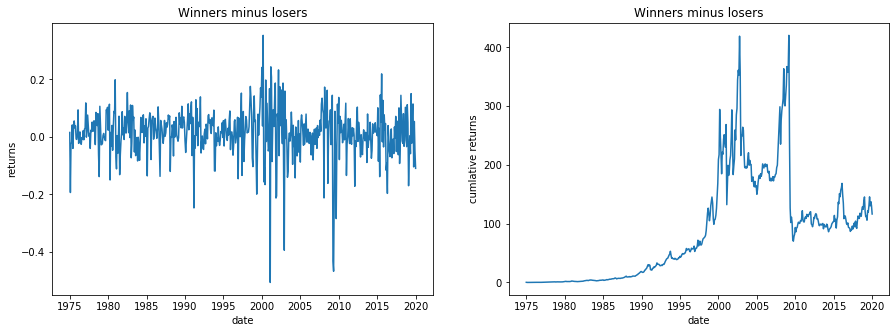

In [10]:
# Plot returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
ax1.plot(deciles['date'], deciles["wml"])
ax1.set_xlabel('date') 
ax1.set_ylabel('returns') 
ax1.set_title('Winners minus losers') 

ax2.plot(deciles['date'], (1 + deciles["wml"]).cumprod() - 1) 
ax2.set_xlabel('date') 
ax2.set_ylabel('cumlative returns') 
ax2.set_title('Winners minus losers') 

plt.show()

In [11]:
# Load Daniel's momentum
daniel = pd.read_csv("m_m_pt_tot.csv", header = None)
daniel.rename(columns = {0:"date", 1:"decile", 2:"ret", 3:"avg_me", 4:"firms"}, inplace = True)
daniel['date'] = pd.to_datetime(daniel['date'], format = '%Y%m%d')
daniel.drop(['avg_me', 'firms'], axis = 1, inplace = True)

daniel = daniel.pivot(index = 'date', columns = 'decile', values = 'ret').reset_index()
daniel['wml'] = daniel[10] - daniel[1]

daniel.head()

decile,date,1,2,3,4,5,6,7,8,9,10,wml
0,1927-01-31,-0.03362,-0.04584,0.02755,-0.00319,-0.00294,0.00893,0.00781,0.00359,-0.00375,-0.00225,0.03137
1,1927-02-28,0.07627,0.05984,0.08206,0.07271,0.03510,0.03040,0.04012,0.03257,0.04169,0.07007,-0.00620
2,1927-03-31,-0.03003,-0.03055,-0.03914,-0.04880,-0.00540,-0.02391,0.02067,0.00850,-0.00034,0.06091,0.09094
3,1927-04-30,0.02042,-0.03130,-0.02379,-0.01262,0.01977,-0.00058,0.02094,-0.00930,0.01809,0.05489,0.03447
4,1927-05-31,0.03949,0.04313,0.06097,0.03178,0.06337,0.05800,0.05219,0.06671,0.08051,0.06231,0.02282


In [12]:
# See correlation; not perfect because momentum construction (intentionally) not exactly same
results = deciles.merge(daniel, on = 'date')

round(results.corr().iloc[0:11 , 11:], 3)

decile,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,wml_y
decile,,,,,,,,,,,
1_x,0.989,0.909,0.858,0.802,0.756,0.706,0.612,0.565,0.508,0.486,-0.740
2_x,0.886,0.987,0.930,0.881,0.836,0.796,0.691,0.635,0.565,0.494,-0.618
3_x,0.842,0.922,0.990,0.923,0.885,0.840,0.728,0.669,0.578,0.488,-0.573
4_x,0.783,0.866,0.909,0.991,0.921,0.885,0.803,0.743,0.624,0.516,-0.485
5_x,0.739,0.822,0.871,0.907,0.992,0.919,0.862,0.817,0.723,0.602,-0.370
6_x,0.679,0.769,0.826,0.879,0.908,0.995,0.922,0.895,0.798,0.671,-0.251
7_x,0.605,0.668,0.728,0.799,0.857,0.915,0.998,0.935,0.864,0.732,-0.121
8_x,0.549,0.614,0.667,0.735,0.812,0.893,0.935,0.998,0.905,0.784,-0.018
9_x,0.515,0.550,0.585,0.631,0.722,0.793,0.865,0.908,0.998,0.886,0.099
